In [50]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(tidyr)
library(ggrepel)

# read switches
candidateInfo <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    mutate(Coocurrent= ifelse(is.na(Coocurrent),FALSE,Coocurrent),
           Candidate = as.logical(Recurrent) | as.logical(AffectingMutatedFeature) | as.logical(Coocurrent)) %>%
    mutate(Candidate = revalue(as.character(Candidate),replace=c("TRUE"="Candidate","FALSE"="Non-candidate"))) %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript,Recurrent,AffectingMutatedFeature,Coocurrent,Candidate)

switches <- read_tsv("../data/pancancer/candidateList_info.tumorSplit.tsv")
switches.agg <- read_tsv("../data/pancancer/candidateList_info.agg.tsv") %>%
    filter(Reliable==1)

# read drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#")

# read mutation data
allPatients <- strsplit(switches.agg$Patients_affected,",") %>% unlist %>% unique

mutations <- read_tsv("../data/mutations/wes_mutations.txt") %>%
  select(Tumor,Patient,Symbol) %>%
  unique %>%
  # filter out patients without RNAseq data available
  filter(Patient %in% allPatients)

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt")

# read interactions
ppi.file <- "../data/structural_analysis/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
         value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction!="") %>%
    # split interaction information
    separate(Interaction, into=c("What","Transcript","Pfams"), sep="-") %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches) %>%
    merge(candidateInfo) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome,by.x=c("Tumor","Transcript"), by.y=c("Cancer","Transcript"), suffixes = c(".switch",".partner"))

Warning message:
: attributes are not identical across measure variables; they will be dropped

# Driver interactor ME

We want to find out if driver interactors that present a interaction gain/loss also tend to be more mutually exclusive than the rest.

In [92]:
# split the patient list
patients <- switches.agg %>%
    filter(IsFunctional==1) %>%
    .$Patients_affected %>%
    strsplit(",")
names(patients) <- switches.agg$Symbol[switches.agg$IsFunctional==1]

interactors.info <- ppi %>%
    select(Symbol.switch,partnerSymbol,What,Patients_affected) %>%
    group_by(Symbol.switch,What) %>%
    mutate(Patients_affected=paste0(Patients_affected,collapse = ",")) %>%
    unique

intx.overlaps <- list()

for (driver in unique(drivers$geneHGNCsymbol)){

    affected.driver.switches <- patients[[driver]]
    affected.driver.muts <- mutations %>%
        filter(Symbol==driver) %>%
        .$Patient

    affected.driver <- unique(c(affected.driver.switches,affected.driver.muts))

    o <- c()

    affected.interactors <- interactors.info %>%
        filter(partnerSymbol==driver)
    
    if (nrow(affected.interactors) > 0){
        for (i in 1:nrow(affected.interactors) ){
        
            interactor <- affected.interactors$Symbol.switch[i]
            affected.interactor.switches <- affected.interactors$Patients_affected[i] %>%
                strsplit(",") %>%
                unlist

            affected.interactor.muts <- mutations %>%
                filter(Symbol==interactor) %>%
                .$Patient

            affected.interactor <- unique(c(affected.interactor.switches,affected.interactor.muts))

            overlap <- length(intersect(affected.driver,affected.interactor))
            overlap.norm <- (overlap+1)/length(affected.interactor)
            o <- c(o,overlap.norm)
            w <- c(w,affected.interactors$What)
        }
        intx.overlaps[[driver]] <- data.frame(Driver=driver, Interactor=affected.interactors$Symbol.switch, 
                                              overlap=o, What=affected.interactors$What )
    }
}

intx.overlaps <- do.call("rbind",intx.overlaps)


	Wilcoxon rank sum test with continuity correction

data:  intx.overlaps$overlap[intx.overlaps$What == "Kept"] and intx.overlaps$overlap[intx.overlaps$What != "Kept"]
W = 206520, p-value = 0.2161
alternative hypothesis: true location shift is not equal to 0


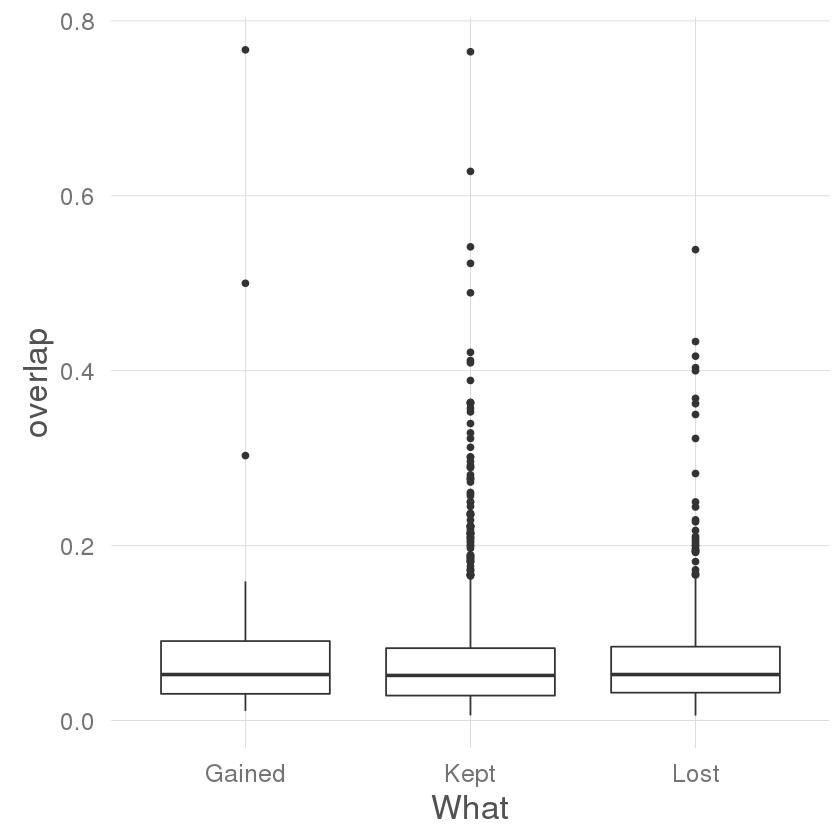

In [99]:
ggplot(intx.overlaps, aes(x=What, y=overlap)) +
    geom_boxplot() +
    smartas_theme()

wilcox.test(intx.overlaps$overlap[intx.overlaps$What=="Kept"],intx.overlaps$overlap[intx.overlaps$What!="Kept"])